# Exercise 3: Multi-class Classification and Neural Networks

In this exercise, you will implement one-vs-all logistic regression and neural
networks to recognize hand-written digits.

In [128]:
# libraries
# data handling
import pandas as pd
import numpy as np
# fit parameters
import scipy as sp
# data visualization
import matplotlib.pyplot as plt

## Multi-class classification
For this exercise, you will use logistic regression and neural networks to
recognize handwritten digits (from 0 to 9). Automated handwritten digit
recognition is widely used today - from recognizing zip codes (postal codes)
on mail envelopes to recognizing amounts written on bank checks. This
exercise will show you how the methods you’ve learned can be used for this
classification task.

In the first part of the exercise, you will extend your previous implemention of logistic regression and apply it to one-vs-all classification.

### Dataset
You are given a data set in `ex3data1.mat` that contains 5000 training examples of handwritten digits.2 The .mat format means that that the data has
been saved in a native Octave/MATLAB matrix format, instead of a text
(ASCII) format like a csv-file. These matrices can be read directly into your
program by using the load command. After loading, matrices of the correct
dimensions and values will appear in your program’s memory. The matrix
will already be named, so you do not need to assign names to them.

Each training
example is a 20 pixel by 20 pixel grayscale image of the digit. Each pixel is
represented by a floating point number indicating the grayscale intensity at
that location. The 20 by 20 grid of pixels is “unrolled” into a 400-dimensional
vector. Each of these training examples becomes a single row in our data
matrix X. This gives us a 5000 by 400 matrix X where every row is a training
example for a handwritten digit image.

The second part of the training set is a 5000-dimensional vector y that
contains labels for the training set. To make things more compatible with
Octave/MATLAB indexing, where there is no zero index, we have mapped
the digit zero to the value ten. Therefore, a “0” digit is labeled as “10”, while
the digits “1” to “9” are labeled as “1” to “9” in their natural order.

In [129]:
# import first dataset
dat = sp.io.loadmat('ex3/ex3data1.mat')
y = np.array(dat['y'],dtype='float') # convert to float because uint8 is problematic
x = np.c_[np.ones(len(y)),dat['X']] # add intercept term
# the 0 digit is labeled as 10! 
y[y == 10] = 0

# check
print(x.shape,y.shape)

(5000, 401) (5000, 1)


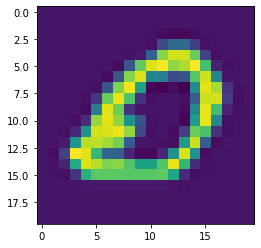

In [140]:
# example
plt.imshow(x[1,1::].reshape(20,20))
plt.show()

[0.]


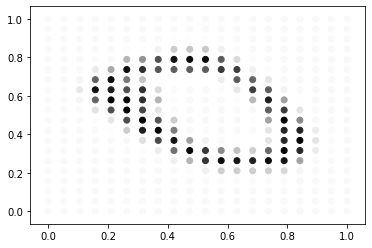

In [130]:
# example
print(y[0]) # the 0 digit is labeled as 10!
x_coord, y_coord = np.meshgrid(np.linspace(0,1,20),np.linspace(0,1,20))
plt.scatter(x_coord.flatten(), y_coord.flatten(),c=x[0,1::],cmap='Greys') # avoid intercept
plt.show()

In [114]:
# balanced categories
np.unique(y, return_counts=True)

(array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]),
 array([500, 500, 500, 500, 500, 500, 500, 500, 500, 500]))

### Vectorizing Logistic Regression
You will be using multiple one-vs-all logistic regression models to build a
multi-class classifier. Since there are 10 classes, you will need to train 10
separate logistic regression classifiers. To make this training efficient, it is
important to ensure that your code is well vectorized. In this section, you
will implement a vectorized version of logistic regression that does not employ
any for loops. You can use your code in the last exercise as a starting point
for this exercise.

#### Vectorizing the cost function
This is the formula of the vectorized version of the cost function (without the regularization terms):

$$J(\theta) = \frac{1}{m} \sum_{i=1}^m [-y^{(i)}log(h_{\theta}(x^{(i)})) - (1-y^{(i)})log(1-h_\theta(x^{(i)}))]$$

Remember that the hypothesis function in logistic regression is the sigmoid function and that it can be quickly computed through matrix multiplication of $X$ and $\theta$.

In this section, write the unregularized cost function using these approaches to avoid introducing loops.

In [115]:
def log_cost_function(theta,x,y):
    """
    Function to compute the vectorized cost function using a sigmoid hypothesis function.
    """
    m = len(y)
    return (1/m)*np.sum( (-y)*np.log(sigmoid(theta,x)) - (1-y)*np.log(1-sigmoid(theta,x)))

#### Vectorizing the gradient
The gradient of unregularized logistic regression cost is a vector of:

$$\frac{\partial J}{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^{m}((h_{\theta}(x^{(i)})-y^{(i)})x_j^{(i)}) \Rightarrow \frac{1}{m}X^T(h_{\theta}(x)-y) $$

The expression above allows us to compute all the partial derivatives
without any loops.

Write the function that computes the vectorized gradient.

In [116]:
def log_compute_gradient(theta,x,y):
    """
    Compute vectorized partial derivative to implement in gradient descent. Returns the partial derivative
    vector for each theta.
    """
    m = len(y)
    return (1/m)*x.T.dot((sigmoid(theta,x)-y))

#### Vectorizing regularized logistic regression

Re-make your code to regularize logistic regression.
Remember that the partial derivative of the cost function is not regularized at the bias term or intercept ($\theta_0$).

In [117]:
# hypothesis function
def sigmoid(theta,x):
    """
    Activation function used to map any real value between 0 and 1.
    """
    return (1 / (1 + np.exp(-x.dot(theta))))

def reg_log_cost_function(theta,x,y,lbda):
    """
    Function to compute the vectorized cost function using a sigmoid hypothesis function and regularized by lbda.
    """
    m = len(y)
    return (1/m)*np.sum( (-y)*np.log(sigmoid(theta,x)) - (1-y)*np.log(1-sigmoid(theta,x))) + (lbda/(2*m))*np.sum(theta[1:]**2)

def reg_log_compute_gradient(theta,x,y,lbda):
    """
    Compute vectorized partial derivative to implement in optimization. Returns the partial derivative
    vector for each theta.
    """
    # compute m
    m = len(y)
    
    # compute j_0 (bias)
    j_0 = ((1/m)*x.T.dot((sigmoid(theta,x)-y)))[0]
    
    # compute the rest of j
    j_rest = ((1/m)*x.T.dot((sigmoid(theta,x)-y)) + (lbda/m)*theta)[1::]
    
    # apped
    J = np.append(j_0,j_rest)
    
    return J

### One-vs-all Classification

In this part of the exercise, you will implement one-vs-all classification by
training multiple regularized logistic regression classifiers, one for each of
the K classes in our dataset (Figure 1). In the handwritten digits dataset,
K = 10, but your code should work for any value of K.

You should now complete your code to train one classifier for
each class. In particular, your code should return all the classifier parameters
in a matrix Θ ∈ R
K×(N+1) , where each row of Θ corresponds to the learned
logistic regression parameters for one class. You can do this with a “for”-loop
from 1 to K, training each classifier independently.
Note that the y argument to this function is a vector of labels from 1 to
10, where we have mapped the digit “0” to the label 10 (to avoid confusions
with indexing).
When training the classifier for class k ∈ {1, ..., K}, you will want a mdimensional vector of labels y, where $y_j$ ∈ 0, 1 indicates whether the j-th
training instance belongs to class k ($y_j$ = 1), or if it belongs to a different
class ($y_j$ = 0). You may find logical arrays helpful for this task.

First, I defined two functions to optimize $\Theta$ by either gradient descent or truncated newton algorithm:

In [118]:
# training by gradient descent
def reg_log_gradient_descent(theta,x,y,l_rate,n_iterations,lbda):
    """
    Perform gradient descent for logistic regression. Output the history of parameter and cost funciton values.
    """
    # initialize costs history vector
    cost = []
    # compute and save initial cost
    cost.append(reg_log_cost_function(theta, x, y,lbda))
    # initialize and save parameters   
    pars_list = [theta]
    
    
    for i in range(n_iterations):
        
        # compute new theta values
        theta_new = theta - l_rate*reg_log_compute_gradient(theta,x,y,lbda) 
        # save
        pars_list.append(theta_new)
        
        # compute and save cost
        cost.append(reg_log_cost_function(theta_new, x, y,lbda))
        
    return [cost,pars_list]

# training by truncated newton optimization
def reg_log_trunew(theta,x,y,lbda):
    """
    Optimizes theta
    """
    
    opt_weights = sp.optimize.minimize(fun = reg_log_cost_function,
                                       x0 = theta,
                                       args=(x, y.flatten(), lbda),
                                       method = 'TNC',
                                       jac = reg_log_compute_gradient)
    
    return opt_weights['x']

Then, I optimized $\theta$ for each digit to carry out the one versus all approach. Each column of $\Theta$ (`Theta`) will correspond to the trained parameters ($\theta$) for each digit:

In [119]:
# selected lbda (regularization term)
lbda = 0.1

# init theta for optimization
theta = np.zeros((x.shape[1],1))

# init Theta for storage of optimized theta
Theta = np.zeros((x.shape[1],len(np.unique(y))))

for i in range(len(np.unique(y))):    
    # optimize using truncated newton because it showed a better performance in former exercises
    # select only rows that contain digit i
    Theta[:,i] = reg_log_trunew(theta,x,(y == i).astype(int),lbda)
    
# check
print(Theta.shape)
print(Theta)

(401, 10)
[[-8.06795029e+00 -3.07409936e+00 -3.72399269e+00 ... -2.29141713e+00
  -9.12578918e+00 -5.62448703e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [-3.53923381e-05  6.82652905e-03  2.31450752e-02 ... -6.63565391e-03
  -6.17008346e-04 -1.12381643e-02]
 [ 9.56380717e-07 -2.26522947e-10 -2.53678841e-03 ...  7.77716736e-04
   6.96378498e-05  8.53722950e-04]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]


#### One-vs-all Prediction

After training your one-vs-all classifier, you can now use it to predict the
digit contained in a given image. For each input, you should compute the
“probability” that it belongs to each class using the trained logistic regression
classifiers. Your one-vs-all prediction function will pick the class for which the
corresponding logistic regression classifier outputs the highest probability and
return the class label (1, 2,..., or K) as the prediction for the input example.

Use the fitted classifier to make predictions.
 You should see that the training set accuracy is about
94.9% (i.e., it classifies 94.9% of the examples in the training set correctly).


For each row in `x`, I will use each set of trained parameters in `Theta` to see which number shows the best prediction.

In [120]:
# predictions using training set

# init predictions vector
preds = np.zeros((x.shape[0],1))

for i in range(x.shape[0]):
    # subset input data
    tmp_x = x[i,:]
    
    # init probability vector:
    probs = np.zeros((len(np.unique(y)),1))
    
    for j in range(len(np.unique(y))):
        # compute probability of digit j
        probs[j] = sigmoid(Theta[:,j],tmp_x)
        
    # save prediction
    preds[i] = np.argmax(probs)
    
# check
print(preds)
# accuracy
acc = sum(preds == y)/len(y)
print('Accuracy:',float(acc)*100)

[[0.]
 [0.]
 [0.]
 ...
 [9.]
 [9.]
 [7.]]
Accuracy: 96.46000000000001


## Neural Networks

In the previous part of this exercise, you implemented multi-class logistic regression to recognize handwritten digits. 
However, logistic regression cannot
form more complex hypotheses as it is only a linear classifier.

In this part of the exercise, you will implement a neural network to recognize handwritten digits using the same training set as before. The neural
network will be able to represent complex models that form non-linear hypotheses. For this week, you will be using parameters from a neural network
that we have already trained. Your goal is to implement the feedforward
propagation algorithm to use our weights for prediction. In next week’s exercise, you will write the backpropagation algorithm for learning the neural
network parameters.

### Model representation

![](fig_nn_ex3.png)

Our neural network is shown in Figure 2. It has 3 layers – an input layer, a
hidden layer and an output layer. Recall that our inputs are pixel values of
digit images. Since the images are of size 20×20, this gives us 400 input layer
units (excluding the extra bias unit which always outputs +1). As before,
the training data will be loaded into the variables X and y.
You have been provided with a set of network parameters (Θ(1)
, Θ(2))
already trained by us.

These are stored in ex3weights.mat and will be
loaded by ex3 nn.m into Theta1 and Theta2 The parameters have dimensions
that are sized for a neural network with 25 units in the second layer and 10
output units (corresponding to the 10 digit classes).


In [124]:
# load trained weights
weights = sp.io.loadmat('ex3/ex3weights.mat')
Theta1 = weights['Theta1'] # hidden layer
Theta2 = weights['Theta2'] # output layer

# swap first and last columns of Theta2, due to legacy from MATLAB indexing, 
# since the weight file ex3weights.mat was saved based on MATLAB indexing
Theta2 = np.roll(Theta2, 1, axis=0)

# check
print(Theta1.shape, Theta2.shape)

(25, 401) (10, 26)


### Feedforward propagation and prediction
Now you will implement feedforward propagation for the neural network. You
will need to complete the code in predict.m to return the neural network’s
prediction.

You should implement the feedforward computation that computes $h_\theta(x^{(i)})$
for every example i and returns the associated predictions. Similar to the
one-vs-all classification strategy, the prediction from the neural network will
be the label that has the largest output $(h_\theta(x))_k$.

You should see that the accuracy is about 97.5%.

Now, for the first layer I will compute the sigmoid function of the input data using each row in `Theta1`.
Then, I will use the outputs of the hidden layer (z) as inputs of the output layer and transform them into boolean.

In [125]:
def predict_nn(Theta1,Theta2,x):
    # init
    a_1 = x
    
    # compute hidden layer and add bias
    a_2 = np.c_[np.ones(len(x)),sigmoid(Theta1.T,a_1)]
    
    # compute output layer
    a_3 = sigmoid(Theta2.T,a_2)
    
    # store the index of the maximum value by row
    pred = np.array(a_3.argmax(axis=1),dtype='float').reshape((o.shape[0],1))
    
    return pred

In [127]:
preds_nn = predict_nn(Theta1,Theta2,x)
# accuracy
acc_nn = np.sum(preds_nn==y)/(len(y))
print('Accuracy NN:',acc_nn*100)

Accuracy NN: 97.52
